### Predict fovea and optic disc location in fundus images

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Resize, CenterCrop
from fundus_image_toolbox.fovea_od_localization import load_fovea_od_model

#### Run inference on images


In [2]:
device = "cpu"

# Choose your model:
#  - "default" for the authors' model
#  - "latest" for the latest model. If you trained a model, this is yours.
#  - or a specific path to the directory containing a checkpoint
checkpoint_dir = "default" 

In [3]:
print("Loading model")
model, checkpoint_path = load_fovea_od_model(checkpoint_dir, device=device, return_test_dataloader=False)

Loading model
Initializing efficientnet-b3 on cpu
Loading model from /gpfs01/berens/user/jgervelmeyer/fundus_image_toolbox/fundus_fovea_od_localization/fundus_fovea_od_localization/models/2024-05-07 11:13.05/multi_efficientnet-b3_best.pt


Inference for a single image

In [4]:
# Get a sample image
url = "https://upload.wikimedia.org/wikipedia/commons/3/37/Fundus_photograph_of_normal_right_eye.jpg"
!wget -O fundus.jpg $url

--2024-10-30 10:20:50--  https://upload.wikimedia.org/wikipedia/commons/3/37/Fundus_photograph_of_normal_right_eye.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253968 (248K) [image/jpeg]
Saving to: 'fundus.jpg'

fundus.jpg          100%[===================>] 248.02K  --.-KB/s    in 0.05s   

2024-10-30 10:20:51 (4.81 MB/s) - 'fundus.jpg' saved [253968/253968]



In [5]:
# Apply the model to an image and get the (x, y) coordinates of the fovea and the optic disc as 
# fovea_x, fovea_y, od_x, od_y
image_path = "fundus.jpg"
fovea_x, fovea_y, od_x, od_y = model.predict(image_path)
print("Fovea:", fovea_x, fovea_y)
print("Optic disc:", od_x, od_y)

Fovea: 701.9563 707.21954
Optic disc: 1178.5085 705.3527


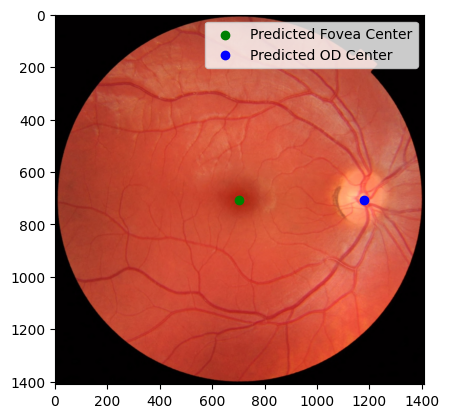

In [6]:
fig, ax = plt.subplots()
ax.imshow(plt.imread(image_path))
ax.scatter(fovea_x, fovea_y, c="g", label="Predicted Fovea Center")
ax.scatter(od_x, od_y, c="b", label="Predicted OD Center")
ax.legend()
plt.show()

Inference for a batch of images

In [8]:
image_paths = [
    Path("../fundus1.jpg"),
    Path("../fundus2.jpg"),
]

In [9]:
# Feed in same sized images of at least 350x350 px
transform = Compose([Resize(350, antialias=True), CenterCrop(350), ToTensor()])

image_batch = torch.stack([transform(Image.open(image_path)) for image_path in image_paths])

print(f"Batch of images: {image_batch.shape}")

Batch of images: torch.Size([2, 3, 350, 350])


In [10]:
labels = model.predict(image_batch)
print("Fovea predictions and OD predictions (fovea_x, fovea_y, od_x, od_y):")
display(labels)

Fovea predictions and OD predictions (fovea_x, fovea_y, od_x, od_y):


[array([121.66878, 170.54135, 220.052  , 148.11272], dtype=float32),
 array([127.41907, 180.25545, 258.12088, 155.63495], dtype=float32)]

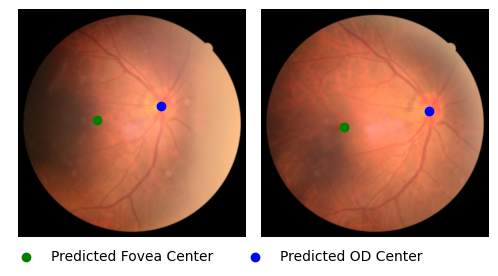

In [11]:
# Plot the images with the predicted labels
fig, axs = plt.subplots(1, len(labels), figsize=(2.5*len(labels), 3))

for (image_path, label, ax) in zip(image_paths, labels, axs.flatten()):
    # Make sure to plot the image in the same size as it was fed into the model
    img = transform(Image.open(image_path)).permute(1, 2, 0)
    ax.imshow(img)
    fovea_x, fovea_y, od_x, od_y = label
    ax.scatter(fovea_x, fovea_y, c="g", label="Predicted Fovea Center")
    ax.scatter(od_x, od_y, c="b", label="Predicted OD Center")
    ax.axis("off")

# Add a legend
fig.legend(["Predicted Fovea Center", "Predicted OD Center"], loc="lower left", ncol=2, frameon=False)
plt.tight_layout()
plt.show()
